# Datos energía solar fotovoltaica

In [2]:
# Librerías empleadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carga de los datos

In [3]:
# Fichero de carga
file = 'data\data_original\solar_stations\Solar station site 1 (Nominal capacity-50MW).xlsx'

# Hemos encontrado que el -99 identifica los valos nulos, pero la función pandas con las columna de enteros no funciona correctamente, por lo que las tenemos que transforma a str y despues otra ves a int
# https://stackoverflow.com/questions/74423168/pandas-read-excel-na-values-not-working-correctly

# Cargamos los datos desde excel
data = pd.read_excel(file, dtype={'Total solar irradiance (W/m2)': str, 'Direct normal irradiance (W/m2)':str, 'Global horizontal irradiance (W/m2)':str}, na_values=-99)

# Mostramos los datos cargados
data.head()

Time(year-month-day h:m:s) Total solar irradiance (W/m2)  \
0        2019-01-01 00:00:00                             0   
1        2019-01-01 00:15:00                             0   
2        2019-01-01 00:30:00                             0   
3        2019-01-01 00:45:00                             0   
4        2019-01-01 01:00:00                             0   

  Direct normal irradiance (W/m2) Global horizontal irradiance (W/m2)  \
0                               0                                   0   
1                               0                                   0   
2                               0                                   0   
3                               0                                   0   
4                               0                                   0   

   Air temperature  (°C)   Atmosphere (hpa)  Relative humidity (%)  Power (MW)  
0                   -11.7             930.5                   39.1         0.0  
1                   -11.8             930.5                   39.3         0.0  
2                   -11.4             930.5                   39.0         0.0  
3                   -11.5             930.5                   38.0         0.0  
4                   -11.5             930.4                   38.9         0.0

## Análisis Exploratorio

Vamos a comprender las variables del dataset:

- **Time (Año-mes-día hora:minuto:segundo)**: Indica el momento en el que se ha registrado la observación.
  
- **Total solar irradiance (TSI, Watios/m²)**: Es la cantidad total de energía solar recibida por unidad de área en la superficie terrestre. Esta medida incluye tanto la radiación solar directa como la radiación difusa reflejada por la atmósfera que alcanza la superficie de la Tierra.

- **Direct normal irradiance (DNI, Watios/m²)**: Representa la cantidad de energía solar que llega a la superficie terrestre en un ángulo perpendicular (90º) al sol. 

- **Global horizontal irradiance (GHI, Watios/m²)**: Es la cantidad de energía solar que alcanza la superficie terrestre en un plano horizontal con respecto al sol.

- **Air Temperature (ºC)**: Es la temperatura ambiente medida en grados Celsius.

- **Atmosphere (hPa)**: Indica la presión del aire en hectopascales, es decir, la fuerza ejercida por el aire sobre una unidad de área.

- **Relative humidity (%)**: Indica el porcentaje de humedad relativa en el momento del registro.

- **Power (MW)**: Es la cantidad de energía eléctrica producida durante el periodo de tiempo registrado, medida en megavatios.

Todas ellas son de tipo numérico

In [4]:
# Mostramos las columnas y filas del dataset original
print(f'El dataset tiene {data.shape[0]} filas y {data.shape[1]} columnas')

El dataset tiene 70176 filas y 8 columnas


## Prepocesamiento y gestión de la variables

### Variables de tiempo

In [5]:
# Transformamos la columna a tipo fecha
data['Time(year-month-day h:m:s)'] = pd.to_datetime(data['Time(year-month-day h:m:s)'], format='%Y-%m-%d %H:%M:%S')

# Facilitamos su nombre
data = data.rename(columns={"Time(year-month-day h:m:s)":"Time"})
# Denotamos la fecha como el indice de los datos ya que nos ayudará a realizar el estudio
data = data.set_index('Time')

### NA Values

In [6]:
# Mostramos la cantidad de valores nulos
data.isnull().sum()

Total solar irradiance (W/m2)          60
Direct normal irradiance (W/m2)        60
Global horizontal irradiance (W/m2)    60
Air temperature  (°C)                  60
Atmosphere (hpa)                       60
Relative humidity (%)                  60
Power (MW)                              0
dtype: int64

Como la proporción de valores nulos es muy pequeña, vamos a eliminarlos, ya que no afectará la resultado de nuestro modelo

In [7]:
# Eliminamos los valores nulos
data_original = data.copy()
data = data.dropna()

In [8]:
# No tenemos valores nulos
data.isnull().sum()

Total solar irradiance (W/m2)          0
Direct normal irradiance (W/m2)        0
Global horizontal irradiance (W/m2)    0
Air temperature  (°C)                  0
Atmosphere (hpa)                       0
Relative humidity (%)                  0
Power (MW)                             0
dtype: int64

In [9]:
# Convertimos las columnas al formato numérico para poder seguir trabajando con ellas
data['Total solar irradiance (W/m2)'] = data['Total solar irradiance (W/m2)'].astype(int)
data['Direct normal irradiance (W/m2)'] = data['Direct normal irradiance (W/m2)'].astype(int)
data['Global horizontal irradiance (W/m2)'] = data['Global horizontal irradiance (W/m2)'].astype(int)

Para continuar con el estudio vamos a resamplear los datos en cada hora, de esa manera eliminamos el ruido que podamos tener debido a la alta desagregación de los datos y evitaremos el sobreajuste del modelo durante el entrenamiento.

In [10]:
hourly_data = pd.DataFrame()

for column in data.columns:
    hourly_data[column] = data[column].resample('h').mean()

hourly_data.head()
# Vamos a añadir dos columnas una con la hora y la otra con el dia del registro, las cuales nos ayudarán al análisis de los datos
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day_of_year'] = hourly_data.index.dayofyear

In [11]:
# Mostramos el resúmen estadístico de nuestros datos
hourly_data.describe()

Total solar irradiance (W/m2)  Direct normal irradiance (W/m2)  \
count                   17534.000000                     17534.000000   
mean                      266.368574                        93.323229   
std                       362.826103                       196.398795   
min                         0.000000                         0.000000   
25%                         0.000000                         0.250000   
50%                        12.250000                         0.750000   
75%                       544.187500                        50.437500   
max                      1175.250000                       962.250000   

       Global horizontal irradiance (W/m2)  Air temperature  (°C)   \
count                         17534.000000            17534.000000   
mean                             67.714878               13.141896   
std                             109.738582               14.331588   
min                               0.000000              -18.050000   
25%                               0.000000               -0.025000   
50%                               7.500000               15.050000   
75%                              99.000000               25.300000   
max                             921.000000               40.400000   

       Atmosphere (hpa)  Relative humidity (%)    Power (MW)          hour  \
count      17534.000000           17534.000000  17534.000000  17544.000000   
mean         913.371395             651.160973      9.674526     11.500000   
std            8.739842            1860.226840     13.567096      6.922384   
min          894.125000               0.050000      0.000000      0.000000   
25%          905.675000               9.625000      0.000000      5.750000   
50%          913.325000              22.000000      0.166358     11.500000   
75%          920.225000              45.625000     18.751674     17.250000   
max          936.200000            6553.400000     48.220699     23.000000   

        day_of_year  
count  17544.000000  
mean     183.250342  
std      105.513966  
min        1.000000  
25%       92.000000  
50%      183.000000  
75%      275.000000  
max      366.000000

Comprobamos que la columna de la humedad tiene datos incorrectos ya que la humedad máxima puede ser 100 y en este caso vemos como el valor máximo es 6553.5, vamos a investigarlo.

In [12]:
#Transformamos los registros con una humedad mayor de 100 a nulos
hourly_data.loc[hourly_data['Relative humidity (%)']>100, 'Relative humidity (%)'] = np.nan

In [13]:
# Comprobamos nuevamente los valores nulos
hourly_data.isnull().sum()

Total solar irradiance (W/m2)            10
Direct normal irradiance (W/m2)          10
Global horizontal irradiance (W/m2)      10
Air temperature  (°C)                    10
Atmosphere (hpa)                         10
Relative humidity (%)                  1948
Power (MW)                               10
hour                                      0
day_of_year                               0
dtype: int64

In [14]:
# Vamos a imputar los valores nulos creando una línea entre los puntos de datos más cercanos.
# Además, tiene un coste computacional bajo
hourly_data.interpolate(method='linear', inplace=True)

In [15]:
# Comprobamos que ya no tenemos nulos
hourly_data.isnull().sum()

Total solar irradiance (W/m2)          0
Direct normal irradiance (W/m2)        0
Global horizontal irradiance (W/m2)    0
Air temperature  (°C)                  0
Atmosphere (hpa)                       0
Relative humidity (%)                  0
Power (MW)                             0
hour                                   0
day_of_year                            0
dtype: int64

### Valores inconsistentes

Si nos ceñimos a la definición de cada tipo de irradiación, la irradiación Total siempre debe ser mayor o igual a las otras irradiaciones, por lo que cuando la irradiación directa o horizontal sean mayores a la total lo denotaremos como incorrecto.

Hay bastantes valores en que a pesar de no haber irradiación (TSI = 0) su valor en el resto de irradiaciones es mayor de 0. De tal manera, llegamos a la conclusión de sustituir estos valores por 0

In [16]:
# Sustituimosa a 0 los valores donde la DNI y GHI, la generación es 0 y la TSI es 0. 
# Ya que entendemos que debe ser un error en la imputación de los valores
hourly_data.loc[(hourly_data["Direct normal irradiance (W/m2)"] > hourly_data["Total solar irradiance (W/m2)"]) 
         & (hourly_data['Power (MW)']==0) 
         & ((hourly_data["Total solar irradiance (W/m2)"]==0) ), 'Direct normal irradiance (W/m2)'] = 0

hourly_data.loc[(hourly_data["Direct normal irradiance (W/m2)"] > hourly_data["Total solar irradiance (W/m2)"]) 
         & (hourly_data['Power (MW)']==0) 
         & ((hourly_data["Total solar irradiance (W/m2)"]==0)), 'Global horizontal irradiance (W/m2)'] = 0

A pesar de haber hecho la corrección anterior, aún tenemos valores erróneos. Pero al solo representar el 5% de los datos optamos por eliminarlos, ya que no nos afectará al resultados del modelo.

In [17]:
idx_del = hourly_data.loc[(hourly_data["Direct normal irradiance (W/m2)"] > hourly_data["Total solar irradiance (W/m2)"])].index
hourly_data.drop(index=idx_del, inplace=True)

In [18]:
idx_del = hourly_data.loc[(hourly_data["Global horizontal irradiance (W/m2)"] > hourly_data["Total solar irradiance (W/m2)"])].index
hourly_data.drop(index=idx_del, inplace=True)

In [19]:
# Actualmente las dimensiones del datset son 
print(f'El dataset tiene {hourly_data.shape[0]} filas y {hourly_data.shape[1]} columnas')

El dataset tiene 16500 filas y 9 columnas


### Análisis de distribuciones
#### Análisis univariante

In [20]:
# Resúmen estadístico del dataset
hourly_data.describe()

Total solar irradiance (W/m2)  Direct normal irradiance (W/m2)  \
count                   16500.000000                     16500.000000   
mean                      270.050331                        81.106735   
std                       369.044895                       183.350724   
min                         0.000000                         0.000000   
25%                         0.000000                         0.000000   
50%                         3.000000                         0.000000   
75%                       566.250000                        28.000000   
max                      1175.250000                       962.250000   

       Global horizontal irradiance (W/m2)  Air temperature  (°C)   \
count                         16500.000000            16500.000000   
mean                             69.243268               12.920392   
std                             112.355360               14.429574   
min                               0.000000              -18.050000   
25%                               0.000000               -0.500000   
50%                               2.000000               14.675000   
75%                             103.000000               25.250000   
max                             921.000000               40.400000   

       Atmosphere (hpa)  Relative humidity (%)    Power (MW)          hour  \
count      16500.000000           16500.000000  16500.000000  16500.000000   
mean         913.494986              21.410296      9.827950     11.483879   
std            8.748587              18.563429     13.784055      7.009785   
min          894.125000               0.050000      0.000000      0.000000   
25%          905.825000               5.500000      0.000000      5.000000   
50%          913.475000              15.875000      0.014758     12.000000   
75%          920.350000              34.275000     19.431899     17.000000   
max          936.200000              69.575000     48.220699     23.000000   

        day_of_year  
count  16500.000000  
mean     182.025636  
std      106.640753  
min        1.000000  
25%       88.000000  
50%      183.000000  
75%      275.000000  
max      366.000000

Podemos ver como las varaibles de irradiación están muy descompensadas, pero esto es debido a que los valores por la noche son 0 y por el día aumentan de manera significativa.

##### Histogramas

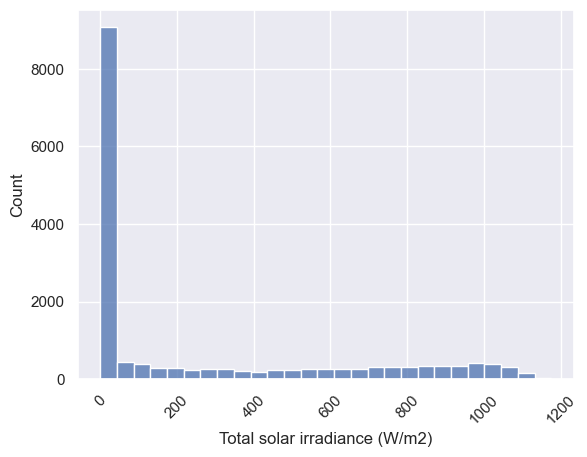

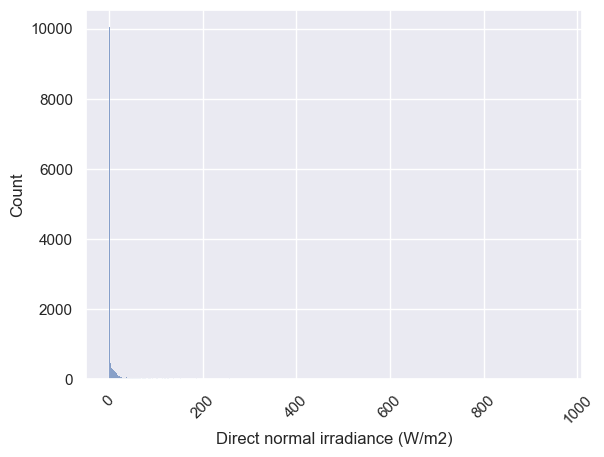

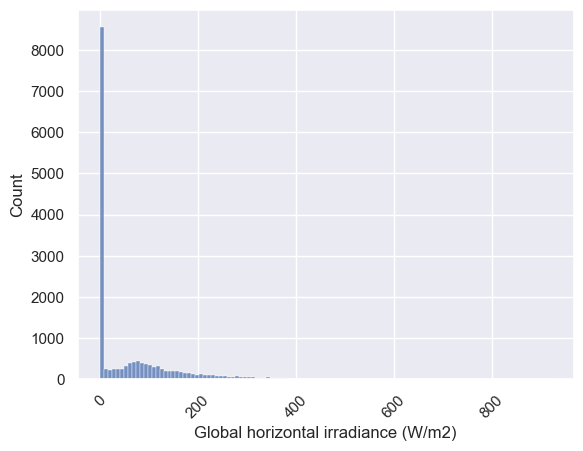

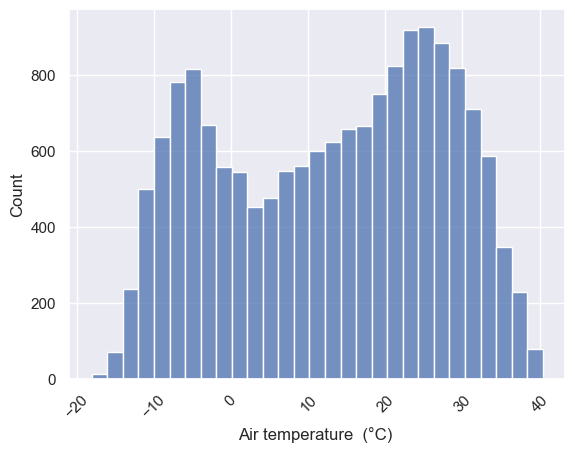

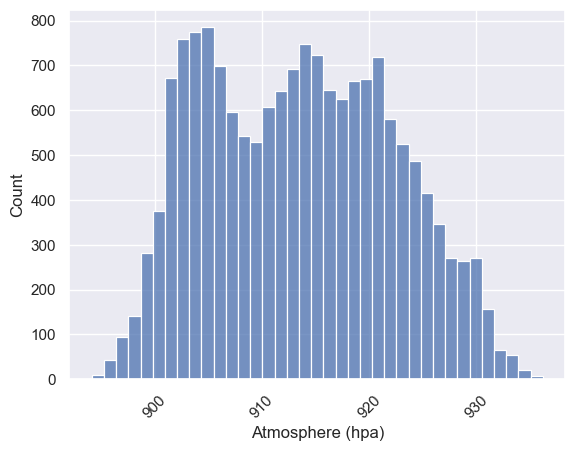

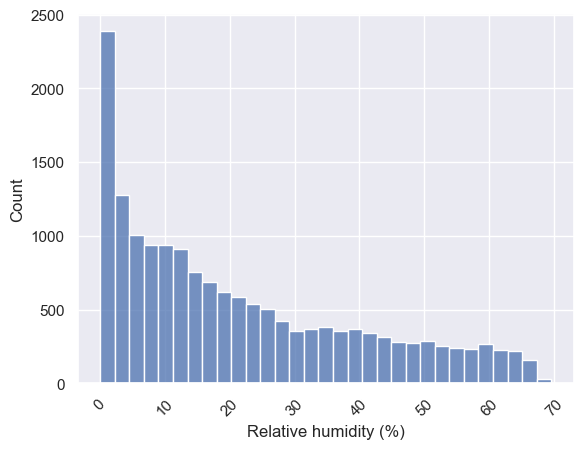

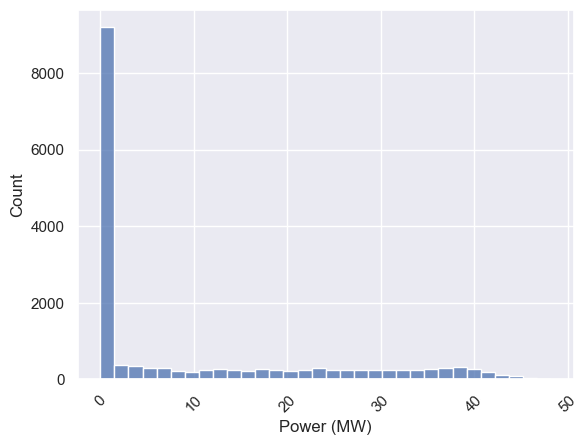

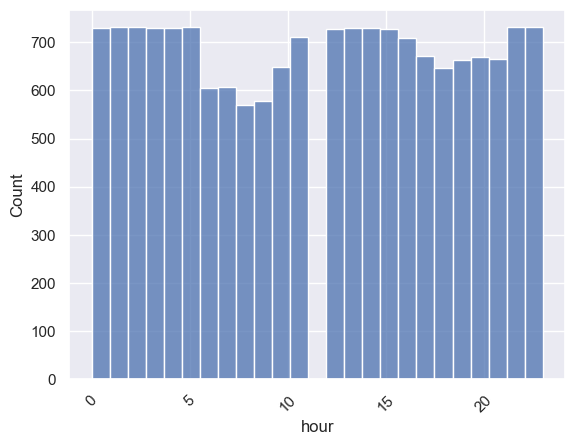

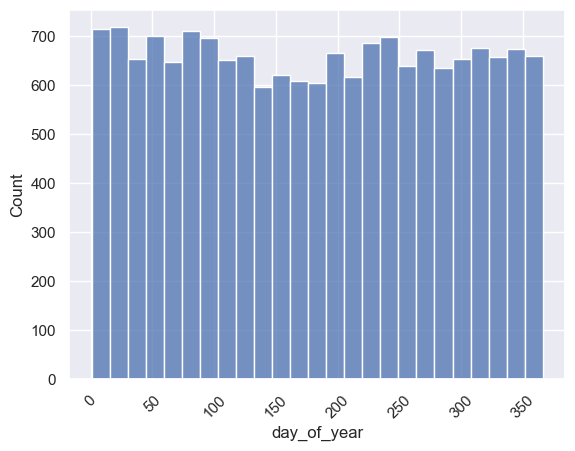

In [21]:
sns.set_theme()
# Obtenemos los nombres de las columnas
columns = hourly_data.columns
for column in columns:
    # Creamos el histograma para cada columna
    sns.histplot(data=hourly_data[column])
    # Rotamos la etiqueta d elos ejes para que no se superpongan
    plt.xticks(rotation=45)
    plt.show()

Si observamos los histogramas, podemos ver como las variables de irradiación y energía generada tienen una cola derecha muy larga, acumulando la mayoria de valores de 0 o cercanos. Esto es debido a que durante la noche, en invierno puede llegar a ser más de 12 horas, no hay ni irradiación ni energía generada. Por este motivo, presentan esta descompensación en los valores. La variable de la temperatura aparentemente tiene una distribución normal y la de la presión atmoférica también parace normal con dos picos. Finalmente, la humedad relativa también es muy baja, por lo que es posible que el lugar donde se encuentren las placas solares sea un región desértica China cercana a Mongolia.

##### Diagramas de cajas

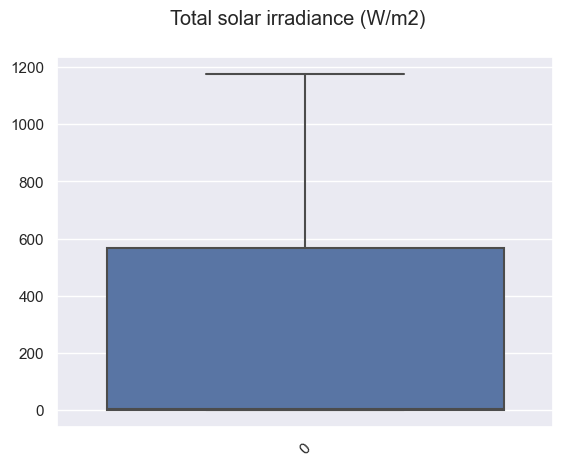

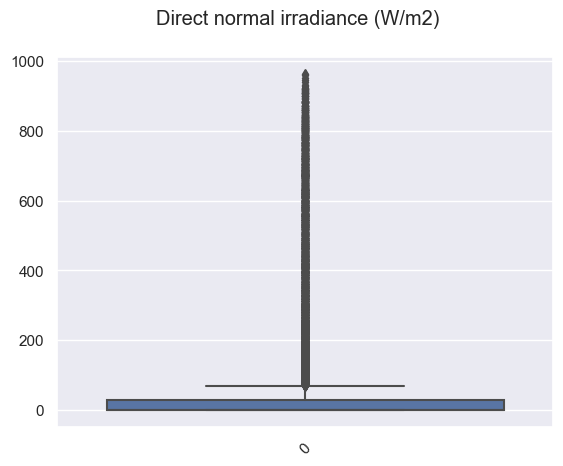

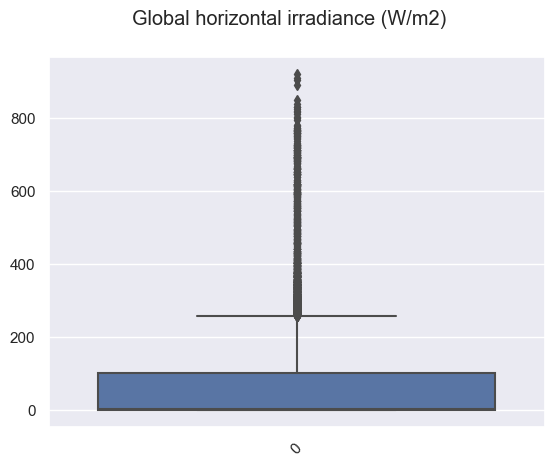

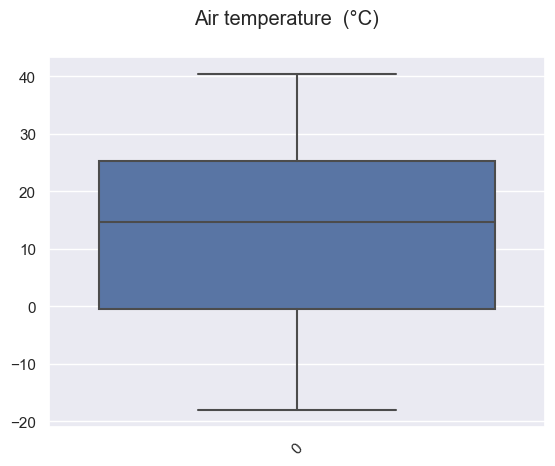

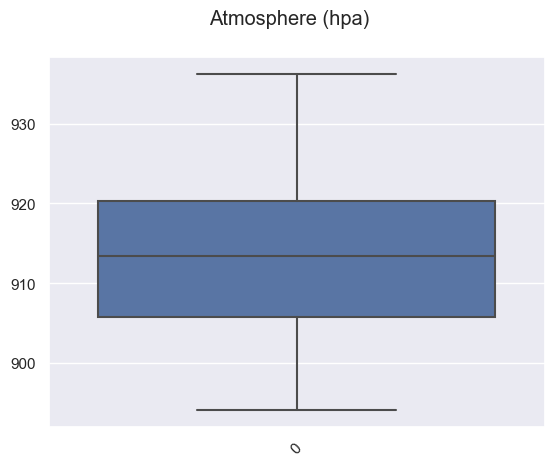

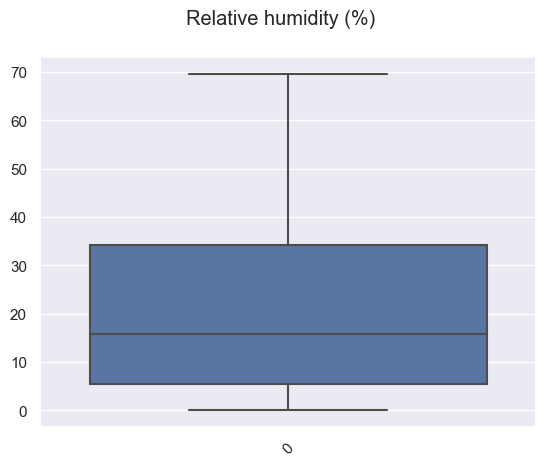

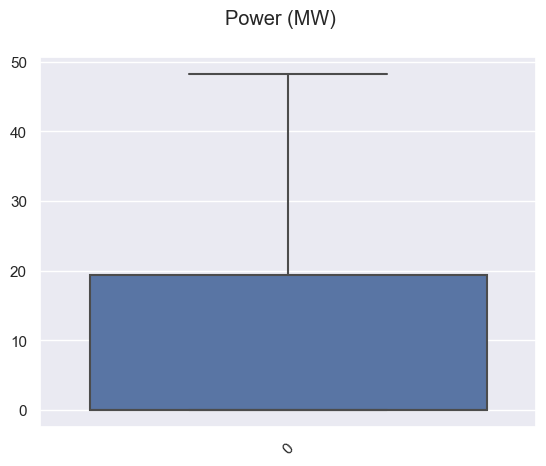

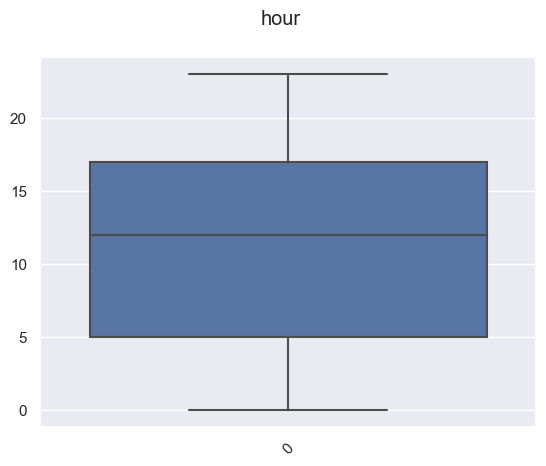

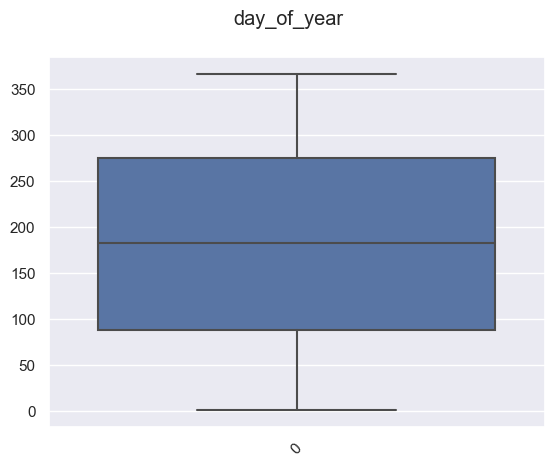

In [22]:
for column in columns:
    # Creamos el diagrama de cajas para cada columna
    sns.boxplot(data=hourly_data[column])
    plt.suptitle(column)
    plt.xticks(rotation=45)
    plt.show()

Si observamos los diagramas de cajas podemos ver como los datos de la irradiación directa y la difusa tienen una gran cantidad de outliers, pero esto no es debido a que los datos sean erróneos, sino que a su valor es dependiente de las condiciones atmosféricas.

##### Análisis outliers DNI

Si nos ceñimos a la definición de DNI, es aquela que nos llega directa a la superficie de la tierra, sin ser reflejada por ningún elemento, por tanto, esperamos que sea alta durante los días soleados y que por tanto haya una diferencia siginificativa en la condiciones atmoféricas entre estos días.

In [23]:
def upper_outliers(data):
    # Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calcular el rango intercuartílico (IQR)
    IQR = Q3 - Q1

    # Calcular el límite superior para los valores atípicos
    return Q3 + 1.5 * IQR

In [24]:
# Seleccionamos dias con una irradiación solar directa con valores atípicos
# El cálculo muestr el IQR, para asi seleecionar los outliers
# Observando el diagrama de cajas sabemos que  solamente tiene outliers por encima

# Calcular los valores atípicos para la variable DNI
outliers_up_DNI = upper_outliers(hourly_data['Direct normal irradiance (W/m2)'])

DNI_sun = hourly_data[hourly_data['Direct normal irradiance (W/m2)'] > outliers_up_DNI][['Air temperature  (°C) ', 'Atmosphere (hpa)', 'Relative humidity (%)', 'Power (MW)']]
# Seleccionamos los vamos no atípicos pero con una generación superior a 0
DNI_cloud = hourly_data[(hourly_data['Direct normal irradiance (W/m2)'] <= outliers_up_DNI)
                & (hourly_data['Power (MW)'] !=0)][['Air temperature  (°C) ', 'Atmosphere (hpa)', 'Relative humidity (%)', 'Power (MW)']]

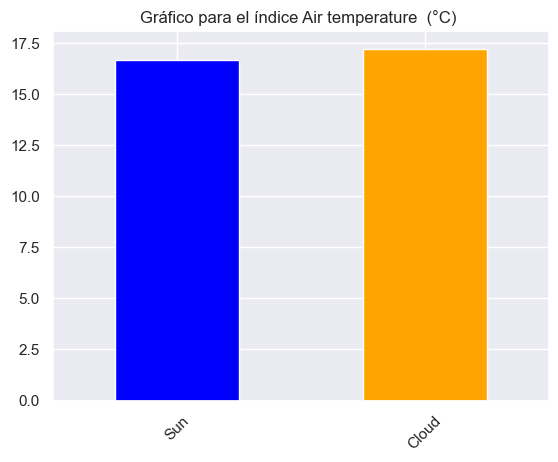

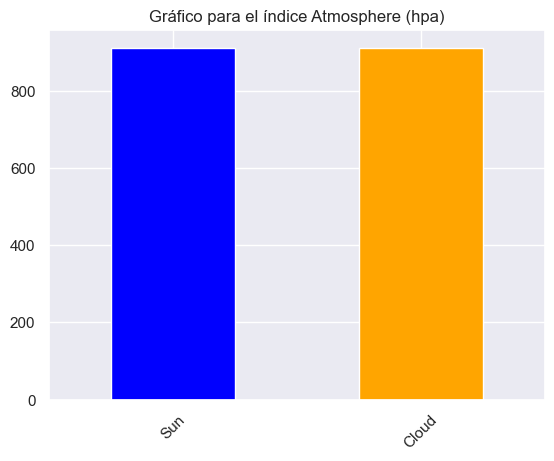

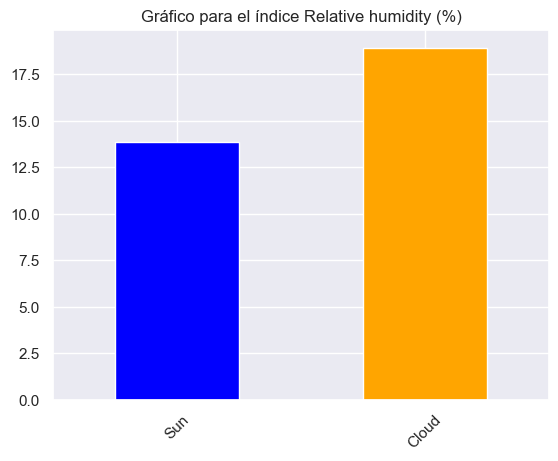

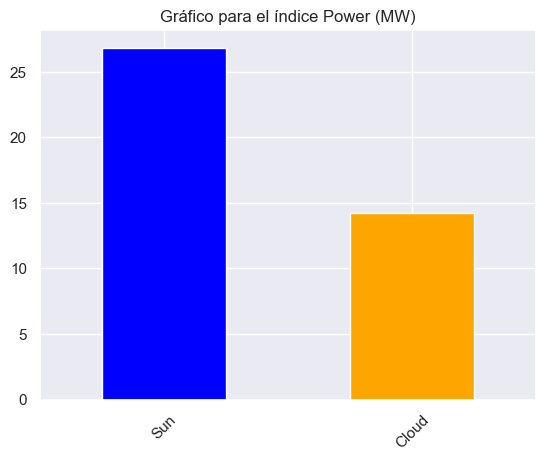

In [25]:
# Obtemos los valores para los dias atípicos
sun = DNI_sun.mean().values

# Seleccionamos los valore pra los días no atípicos
cloud = DNI_cloud.mean().values
index = DNI_cloud.mean().index

# Creamos el dataframe
DNI = pd.DataFrame({'Sun':sun, 'Cloud':cloud}, index=index)

colores = ['blue', 'orange']

# Iteramos sobre cada índice y crea un gráfico para cada uno
for index in DNI.index:
    plt.figure()  # Creamos una nueva figura para cada gráfico
    DNI.loc[index].plot(kind='bar', rot=45, color=colores)  # Graficamos el índice actual
    plt.title(f'Gráfico para el índice {index}')  # Añadimos un título
    plt.show()  

Como podemos comprobar para los días más soleados (atípicos), tenemos una temperatura media más baja, a pesar de que esto en un prinicipio nos parezca contradictrorio, puede tener una explicación. Esto se puede deber a que durante un anticiclón y días soleados asociados, el aire frío tiende a permanecer estancado en la superficie debido a la falta de movimientos convectivos, lo que resulta en temperaturas más bajas a nivel del suelo. Mientras que, en días nublados, las nubes pueden actuar como una especie de tapón y es posible que retengan el calor irradiado por la superficie terrestre, actuando como una especie de manta térmica que evita que la temperatura descienda tanto como en días despejados. Este mismo fenómeno de anticiclón lo podemos relacionar con que el valor de la presión atmosféricas, pues en épocas anticiclónicas la presión atmosférica aumenta, mientras que en días nublados desciende. Lo mismo pasa con la humadad relativa, durante dias soleados (anticiclónicso) la humedad se reduce debido a que el calor la evapora, mientras que durante días nublados la humedad aumenta.

Finalmente, vamos a comprobamos que durante estos días más soleado se genera más energía por tanto, no los podmeos considerar datos erróneos, ya que, al recibir más irradición también se genera más energía, y pueden ser datos muy importantes para nuestro modelo. 

En consecuencia, vamos a comprobar si sus valores son siginificativamente difrenetes y saber como son los días anticiclónicos. Para verificar si hay una diferencia significativa entre las medias, utilizaremos el t-test con un nivel de confianza del 95%. Si el p-valor es menor que 0.05, podemos concluir con un nivel de confianza del 95% que existe una diferencia significativa entre las medias.

Podemos emplear el t-test, ya que, por el Teorema Central de Límite (TCL) al tener más de 30 observaciones podemos asumir que tiene una distribución normal

In [26]:
from scipy import stats
# con alpha denotamoe el nivel de confianza
def comparar_medias(data1, data2, alpha=0.05):
    # aplicamos el t-test
    t_stat, p_val = stats.ttest_ind(data1, data2)
    if p_val < alpha:
        return "Las medias son significativamente diferentes (p < {:.2f})".format(alpha)
    else:
        return "Las medias no son significativamente diferentes (p >= {:.2f})".format(alpha)

In [27]:
# Seleccionamos los valores
air_sun = DNI_sun['Air temperature  (°C) '].values
air_cloud = DNI_cloud['Air temperature  (°C) '].values

# Comparamos las medias
comparar_medias(air_sun, air_cloud)

'Las medias no son significativamente diferentes (p >= 0.05)'

In [28]:
# Seleccionamos los valores
atm_sun  = DNI_sun['Atmosphere (hpa)'].values
atm_cloud = DNI_cloud['Atmosphere (hpa)'].values

# Comparamos las medias
comparar_medias(atm_sun, atm_cloud)

'Las medias son significativamente diferentes (p < 0.05)'

In [29]:
# Seleccionamos los valores
hum_sun = DNI_sun['Relative humidity (%)'].values
hum_cloud = DNI_cloud['Relative humidity (%)'].values

# Comparamos las medias
comparar_medias(hum_sun, hum_cloud)

'Las medias son significativamente diferentes (p < 0.05)'

In [30]:
# Seleccionamos los valores
pow_sun= DNI_sun['Power (MW)'].values
pow_cloud = DNI_cloud['Power (MW)'].values

# Comparamos las medias
comparar_medias(pow_sun, pow_cloud)

'Las medias son significativamente diferentes (p < 0.05)'

Podemos concluir que los días con una irradiación directa normal con valores atípicos, tienen una presión atmoférica y una generación de energía siginificativamente más alta. Mientras que, las humedad es significativamente más baja. Sin embargo, la temperatura entre cada grupo no es siginificativamente diferente.

##### Análisis outliers GHI

Si nos ceñimos a la definición de GHI, es aquella que nos llega directa a la superficie de la tierra, además de tener cuanta aquella que es reflejada por la nubes, por lo tanto no podmeos atribuir directamente las mismas características atomféricas que antes. 

In [31]:
# Seleccionamos dias con una irradiación solar directa con valores atípicos
# El cálculo muestr el IQR, para asi seleecionar los outliers

# Calcular los valores atípicos para la variable GHI
outliers_up_GHI = upper_outliers(hourly_data['Global horizontal irradiance (W/m2)'])

GHI_out = hourly_data[hourly_data['Global horizontal irradiance (W/m2)'] > outliers_up_GHI][['Air temperature  (°C) ', 'Atmosphere (hpa)', 'Relative humidity (%)', 'Power (MW)']]

# Seleccionamos los vamos no atípicos pero con una generación superior a 0
GHI_no_out = hourly_data[(hourly_data['Global horizontal irradiance (W/m2)'] <= outliers_up_GHI)
                & (hourly_data['Power (MW)'] !=0)][['Air temperature  (°C) ', 'Atmosphere (hpa)', 'Relative humidity (%)', 'Power (MW)']]

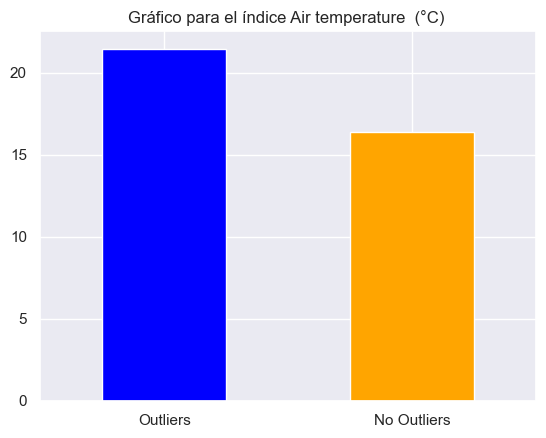

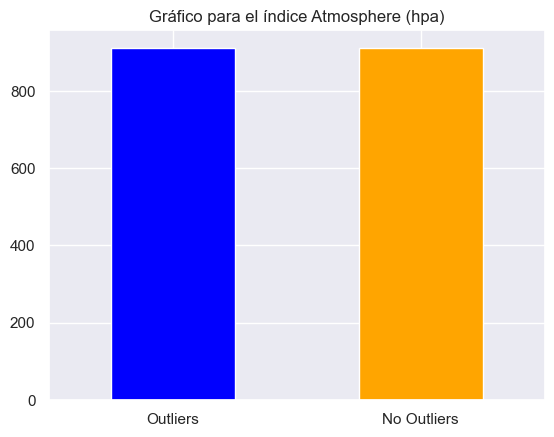

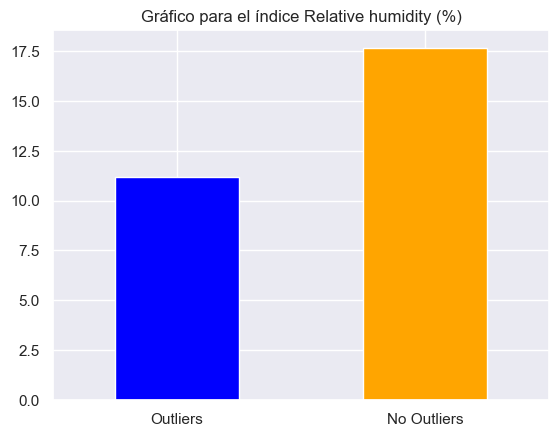

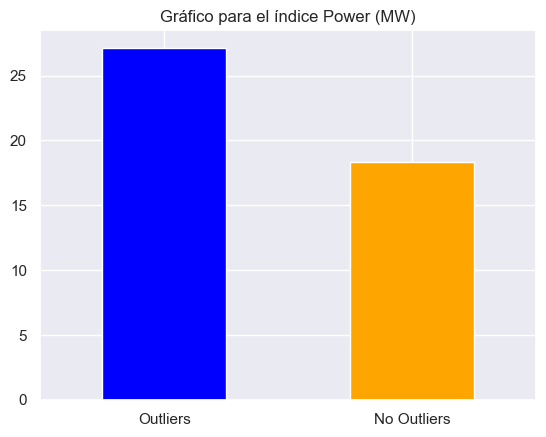

In [32]:
# Obtemos los valores para los dias atípicos
outliers = GHI_out.mean().values

# Seleccionamos los valore pra los días no atípicos
no_outliers = GHI_no_out.mean().values
index = GHI_no_out.mean().index

# Creamos el dataframe
GHI = pd.DataFrame({'Outliers':outliers, 'No Outliers':no_outliers}, index=index)

colores = ['blue', 'orange']

# Iteramos sobre cada índice y crea un gráfico para cada uno
for index in GHI.index:
    plt.figure()  # Creamos una nueva figura para cada gráfico
    GHI.loc[index].plot(kind='bar', rot=0, color=colores)  # Graficamos el índice actual
    plt.title(f'Gráfico para el índice {index}')  # Añadimos un título
    plt.show() 

En este caso, efectivamente observamos una correlación entre una temperatura más alta y una mayor irradiación solar. Sin embargo, es importante destacar que al tener en cuenta la irradiación reflejada por las nubes, dentro de este conjunto de registros podemos incluir días nublados (no necesariamente anticiclónicos), lo que podría explicar por qué la presión atmosférica es menor. A pesar de esto, es notable que la humedad relativa es menor, lo que no coincide con los días típicamente nublados. Por lo tanto, podemos concluir que esta variable engloba tanto días soleados como nublados, sin distinguir entre ellos claramente.

Finalmente, podemos corroborar que una vez más a más irradiación más energía se genera.

En consecuencia, vamos a comprobar si sus valores son siginificativamente difrenetes y saber como son los días anticiclónicos. Para verificar si hay una diferencia significativa entre las medias, utilizaremos el t-test con un nivel de confianza del 95%. Si el p-valor es menor que 0.05, podemos concluir con un nivel de confianza del 95% que existe una diferencia significativa entre las medias.

Podemos emplear el t-test, ya que, por el Teorema Central de Límite (TCL) al tener más de 30 observaciones podemos asumir que tiene una distribución normal

In [33]:
# Seleccionamos los valores
air_out = GHI_out['Air temperature  (°C) '].values
air_no_out = GHI_no_out['Air temperature  (°C) '].values

# Comparamos las medias
comparar_medias(air_out, air_no_out)

'Las medias son significativamente diferentes (p < 0.05)'

In [34]:
# Seleccionamos los valores
atm_out  = GHI_out['Atmosphere (hpa)'].values
atm_no_out = GHI_no_out['Atmosphere (hpa)'].values

# Comparamos las medias
comparar_medias(atm_out, atm_no_out)

'Las medias son significativamente diferentes (p < 0.05)'

In [35]:
# Seleccionamos los valores
hum_out = GHI_out['Relative humidity (%)'].values
hum_no_out = GHI_no_out['Relative humidity (%)'].values

# Comparamos las medias
comparar_medias(hum_out, hum_no_out)

'Las medias son significativamente diferentes (p < 0.05)'

In [36]:
# Seleccionamos los valores
pow_out = GHI_out['Power (MW)'].values
pow_no_out = GHI_no_out['Power (MW)'].values

# Comparamos las medias
comparar_medias(pow_out, pow_no_out)

'Las medias son significativamente diferentes (p < 0.05)'

Los outliers tienen una temperatura significativamente mayor y una presión y humedad relativa significativamente menor. Además, al recibir más irradiación sí que generan más energía de manera significativa.

#### Análisis bivariante
##### Correlaciones

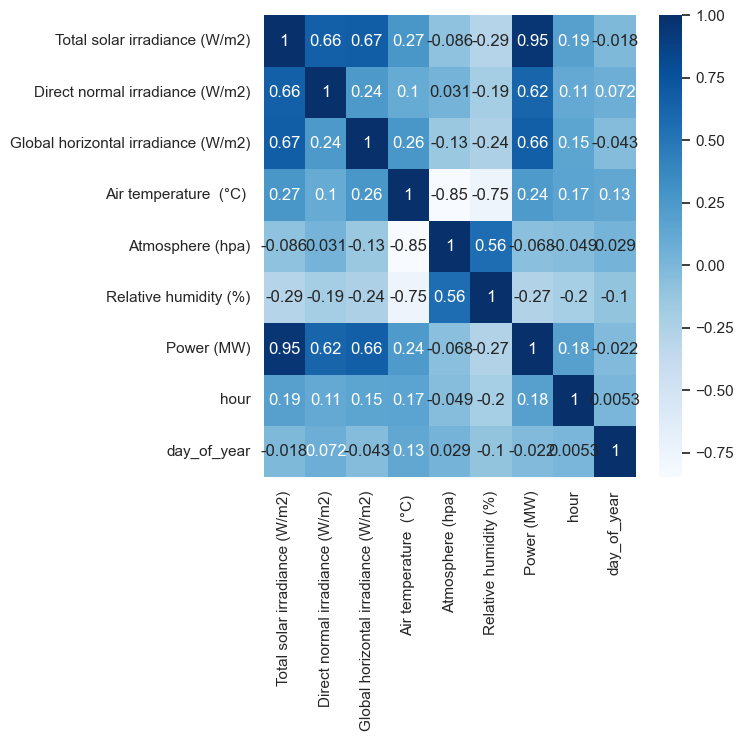

In [37]:
# Se crea una figura con un tamaño específico (6x6 pulgadas)
figure = plt.figure(figsize=(6, 6))

# Se utiliza la función heatmap de seaborn para visualizar la matriz de correlación de hourly_data
# annot=True agrega etiquetas de valores en cada celda
# cmap=plt.cm.Blues establece el esquema de color del mapa de calor a tonos de azul
sns.heatmap(hourly_data.corr(), annot=True, cmap=plt.cm.Blues)

# Se muestra la visualización
plt.show()


Como era de esperar, todas las variables de irradiación muestran una correlación positiva entre sí, destacándose especialmente la variable TSI (Irradiancia Solar Total). Dado que esta última abarca todas las demás radiaciones, es probable que surja multicolinealidad si todas estas variables se emplean en el modelo. De hecho, TSI presenta una correlación muy alta de 0.95 con nuestra variable objetivo, lo que la convierte en una candidata muy interesante para incluir en nuestro modelo.

La temperatura y la hora presentan una correlación positiva con la energía generada pero en menor medida. El resto de variables no parecen estar correlacionadas con la cantidad de energía generada.

c:\Users\josor\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


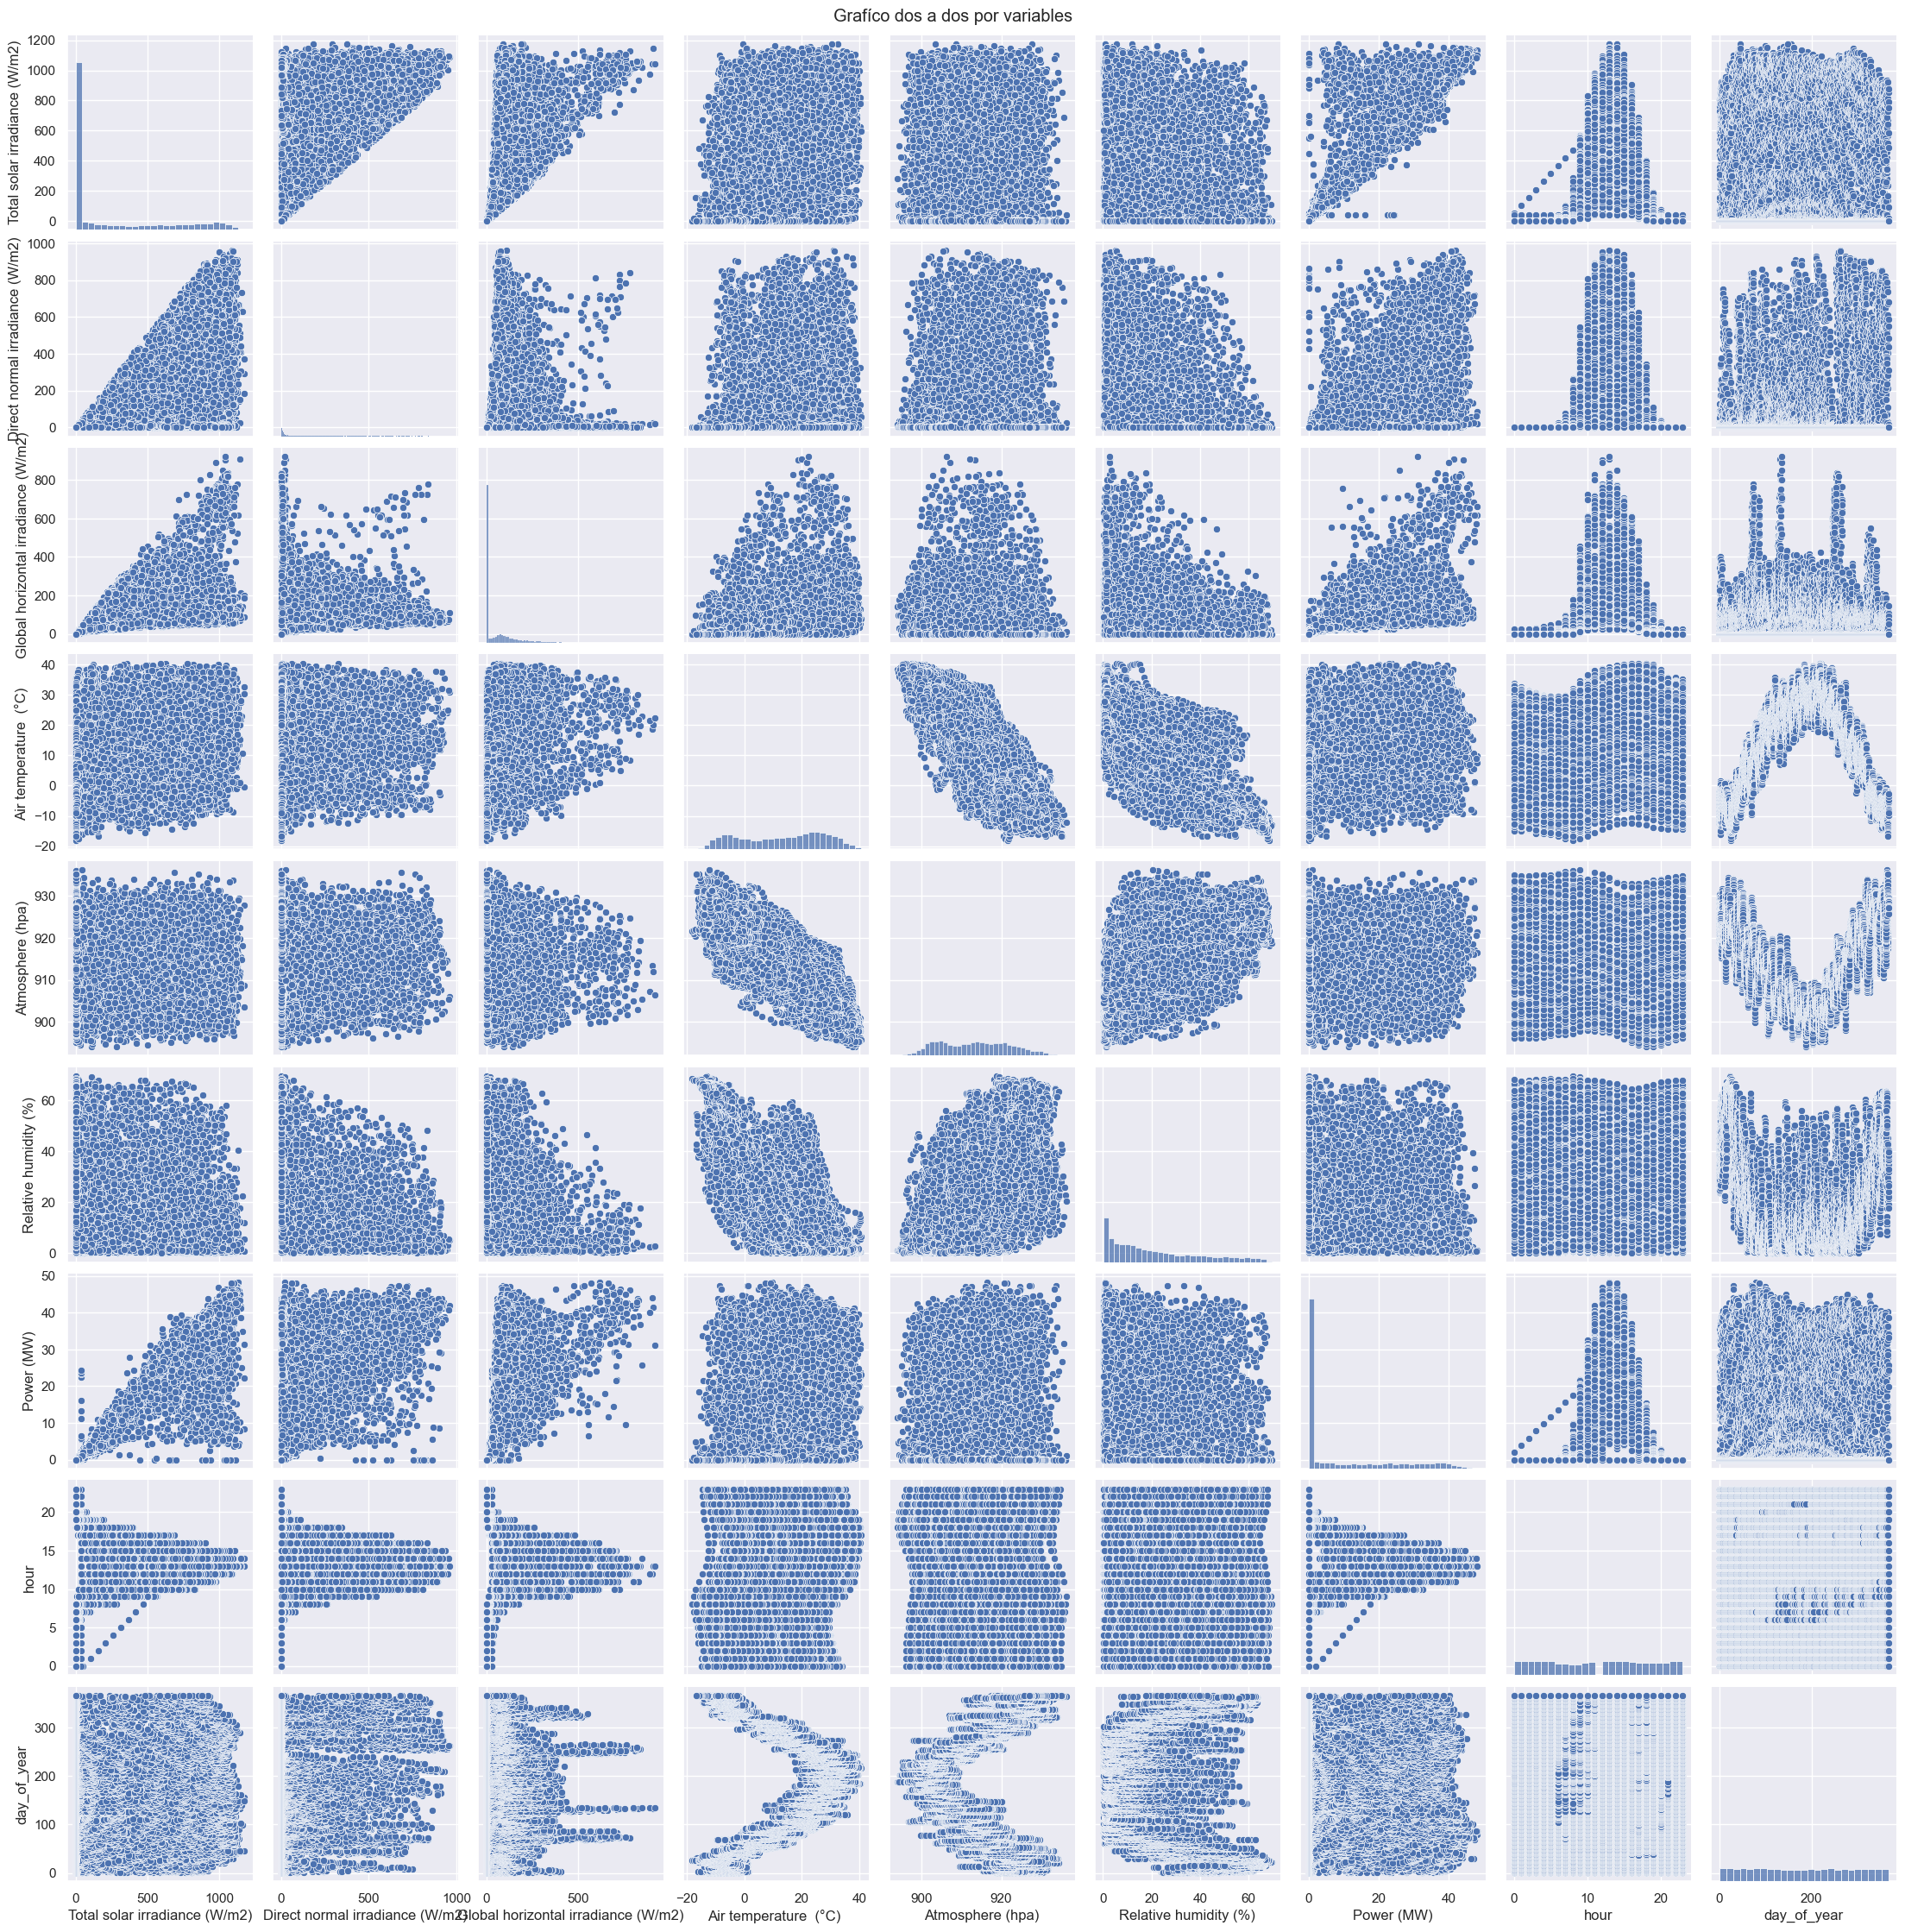

In [38]:
# Realizamos el gráfico dos a dos
g = sns.pairplot(hourly_data)

# Indicamos el título
g.figure.suptitle("Grafíco dos a dos por variables", y=1)
plt.show()

De este gráfico podemos extrear las siguientes conclusiones y preguntas que intentaremos responder a continuación:

- Podemos comprobar como existe una fuerte correlación positiva entre la energia generada y la irradiciación total directa
- Las horas de generación, parce que aparantemente presentan una distribución normal, pero ¿exactemente a que horas se genera energía solar fotovoltaica?
- Se puede apreciar como la energía generada durante los diferentes días del año es diferente, pero ¿esta diferencia es significativa?
- Vemos como las variables atmosféricas como la temperatura del aire, presión atmoférica y humedad relativa no parecen tener una influencia importante en la predicción de la energía generada, ya que, su distribución de datos no muestra una correalación siginificativa con la variable a predecir.

**¿A que horas de media se genera energía?**

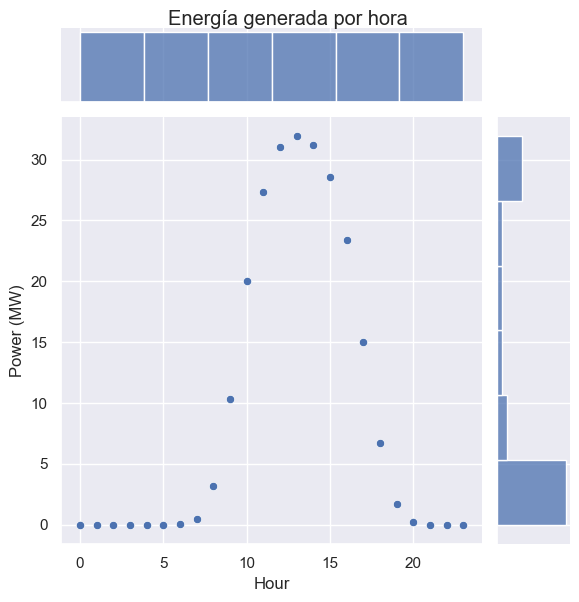

In [39]:
# Se crea un gráfico de dispersión conjunto (jointplot) utilizando seaborn
# Se selecciona un subconjunto de datos de hourly_data que incluye solo las columnas "hour" y "Power (MW)"
# y se calcula el valor medio de "Power (MW)" para cada hora
g = sns.jointplot(data=hourly_data[["hour", "Power (MW)"]].groupby("hour").mean(), x="hour", y="Power (MW)")

# Se establecen las etiquetas de los ejes x e y del gráfico
g.set_axis_labels(xlabel=("Hour"), ylabel=("Power (MW)"))

# Se establece el título del gráfico
g.figure.suptitle("Energía generada por hora", y=1)

# Se muestra el gráfico
plt.show()

Como se puede comprobar en el gráfico, generalmnete a partir de las 6 de la maña se empieza a generar energía hasta 20 de la tarde. En el resto de horas la generación es 0 o muy próximo.

Sin embargo, como todos sabemos, las horas de sol durante los diferentes meses del año no son iguales, por lo que vamos a estudiar si la generación de energía presenta una distribución estacional. De hecho, nuestra hipótesis es que durante los meses de verano y primavera donde los días son más largos, la energía generada debería ser significativamente mayor a laos meses de invierno y otoño.

Para continuar con el análisis, vamos a eliminar los datos en las que en una hora se ha generado menos de un vatio, de esta manera quitamos datos que no nos van a aportar información relevante respecto a la generación de energía solar fotovoltaica.

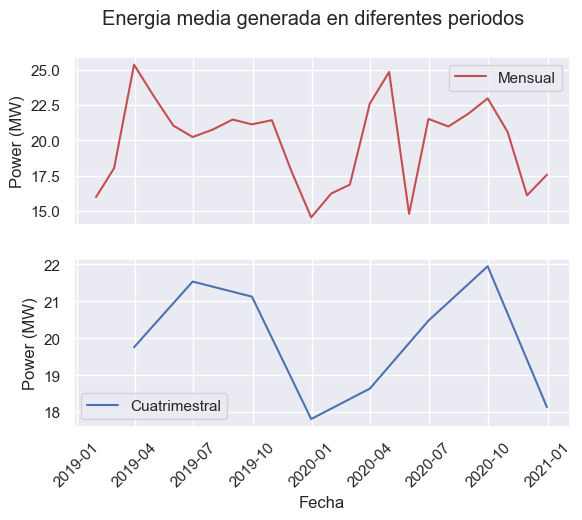

In [40]:
list_hours = [k for k,v in (hourly_data.groupby("hour")["Power (MW)"].mean() > 1).to_dict().items() if v is True]

filtered_data = hourly_data[hourly_data.hour.isin(list_hours)]

# Obtemeos los datos mensuales y cuatrimestrales
month = filtered_data['Power (MW)'].resample('1M').mean()
quarter = filtered_data['Power (MW)'].resample('1Q').mean()


# Se crea una figura y dos ejes utilizando subplots
# 2, 1 indica que habrá dos subtramas en una columna
# sharex=True establece que los ejes x serán compartidos entre las dos subtramas
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)


# Creamos los gráficos de líneas utilizando seaborn
# sns.lineplot para el gráfico mensual
# x=month.index y y=month.values representan el índice (fecha) y los valores (energía) del gráfico mensual respectivamente
# color="r" establece el color de la línea a rojo
# ax=ax1 indica que el gráfico se ubicará en el primer eje (ax1)
# label='Mensual' agrega una etiqueta al gráfico mensual
sns.lineplot(x=month.index, y=month.values, color="r", ax=ax1, label='Mensual')

# sns.lineplot para el gráfico cuatrimestral con parámetros similares al gráfico mensual
sns.lineplot(x=quarter.index, y=quarter.values, color="b", ax=ax2, label='Cuatrimestral')

# Diseñamos el gráfico
plt.suptitle("Energia media generada en diferentes periodos")  # Establecemos el título del gráfico
ax1.set_ylabel("Power (MW)")  # Establecemos la etiqueta del eje y del primer gráfico
ax2.set_ylabel("Power (MW)")  # Establecemos la etiqueta del eje y del segundo gráfico
plt.xlabel("Fecha")  # Establecemos la etiqueta del eje x
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje x para mejorar la legibilidad
plt.show()  # Mostramos el gráfico

A partir de este gráfico, podemos observar que los meses de primavera y verano, con la excepción de junio de 2020, donde posiblemente se haya presentado algún problema en el funcionamiento de las plantas solares, son los periodos del año en los que se genera más energía solar fotovoltaica. Este patrón es coherente, ya que corresponde a las épocas del año en las que los días son más largos en el hemisferio norte, particularmente en China en este caso. ¿Pero es sigificativa esta diferencia?

**Vamos a comprobarlo por estaciones especificamente**

In [41]:
# Vamos a añadir el mes a cada registro de nustros datos filtrados a partir de ellos denotaremos la estación
filtered_data.loc[:, 'month'] = filtered_data.index.month_name()

season_dict = {'January': 'Winter',
               'February': 'Winter',
               'March': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'July': 'Summer',
               'August': 'Summer',
               'September': 'Fall',
               'October': 'Fall',
               'November': 'Fall',
               'December': 'Winter'}

filtered_data.loc[:, 'season'] = filtered_data['month'].apply(lambda x: season_dict[x])

C:\Users\josor\AppData\Local\Temp\ipykernel_34184\260484414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'month'] = filtered_data.index.month_name()
C:\Users\josor\AppData\Local\Temp\ipykernel_34184\260484414.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'season'] = filtered_data['month'].apply(lambda x: season_dict[x])


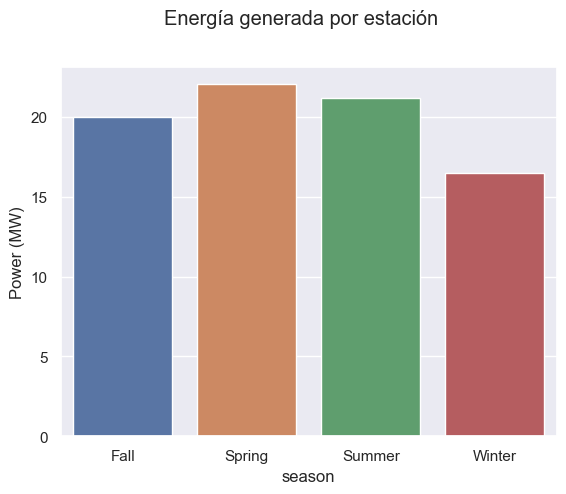

In [42]:
# Se crea un gráfico de barras utilizando seaborn
# Se selecciona un subconjunto de datos de filtered_data que incluye solo las columnas "season" y "Power (MW)"
# Se agrupa por "season" y se calcula la media de "Power (MW)" para cada estación
# Se reinicia el índice para obtener "season" como una columna regular
# x="season" indica que "season" será el eje x del gráfico de barras
# y="Power (MW)" indica que "Power (MW)" será el eje y del gráfico de barras
g = sns.barplot(data=filtered_data[["season", "Power (MW)"]].groupby("season").mean().reset_index(), x="season", y="Power (MW)")

# Se establece el título de la figura
g.figure.suptitle("Energía generada por estación", y=1)

# Se muestra el gráfico de barras
plt.show()


Podemos comprobar como sí que se genera más energía en los periodos de primavera-verano que en otoño-invierno

Para verificar si hay una diferencia significativa entre las medias, utilizaremos el t-test con un nivel de confianza del 95%. Si el p-valor es menor que 0.05, podemos concluir con un nivel de confianza del 95% que existe una diferencia significativa entre las medias.

Podemos emplear el t-test, ya que, por el Teorema Central de Límite (TCL) al tener más de 30 observaciones podemos asumir que tiene una distribución normal

In [43]:
from scipy import stats

# Obtemos los valores para las épocas de verano-primavera y otoño-invierno
short_days = filtered_data[(filtered_data['season'] == 'Winter') | (filtered_data['season'] == 'Fall')]['Power (MW)'].values
long_days = filtered_data[(filtered_data['season'] == 'Summer') | (filtered_data['season'] == 'Spring')]['Power (MW)'].values

stats.ttest_ind(short_days, long_days)

TtestResult(statistic=-11.28415421191398, pvalue=2.5974104526400944e-29, df=8108.0)

Como el p-valor es prácticamente 0, podemos afirmar con un 95% de confianza que las medias de generación entre estaciónes del año son significativamente diferentes. Por tanto, esto nos constata que es posible que los datos tengan una distribución estacional.

**Relaciones no lineales**

##### Presión atmoférica

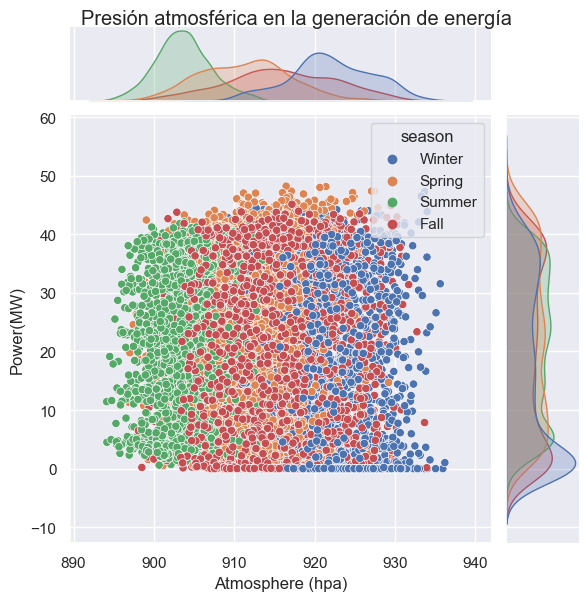

In [44]:
# Se crea un gráfico de dispersión conjunto (jointplot) utilizando seaborn
# Se utiliza filtered_data como el conjunto de datos
# x="Atmosphere (hpa)" indica que "Atmosphere (hpa)" será el eje x del gráfico
# y="Power (MW)" indica que "Power (MW)" será el eje y del gráfico
# hue='season' permite diferenciar las observaciones por estación utilizando diferentes colores
g = sns.jointplot(data=filtered_data, x="Atmosphere (hpa)", y="Power (MW)", hue='season')

# Se establecen las etiquetas de los ejes x e y del gráfico
g.set_axis_labels(xlabel=("Atmosphere (hpa)"), ylabel=("Power(MW)")) 

# Se establece el título de la figura
g.figure.suptitle("Presión atmosférica en la generación de energía", y=1)

# Se muestra el gráfico de dispersión conjunto
plt.show()


En el caso de la presión atmosférica, podemos ver claramente como no tiene relación lineal con la energía generada, pues todos los datos estar repartidos de manera más o menos uniforme. Sin embargo, si hacemos la división por estaciones sí que observamos algunas difrencias. En este caso, las presión atmoféricas más bajas se concentran durante el verano, lo que indica que en la zona donde se aloja la planta solar el verano (verde) puede traer más lluvias. Mientras que, primavera (Naranja) y otoño (rojo) es una época de transición donde los valores se mezclan, hasta llegar al invierno (invierno) donde se acumulan la mayor de valores altos de la presión atmosférica, lo que nos recuerda como en análisis anterior los dias soleados (anticiclónicos) tenía una temperatura media más baja.

##### Temperatura del aire

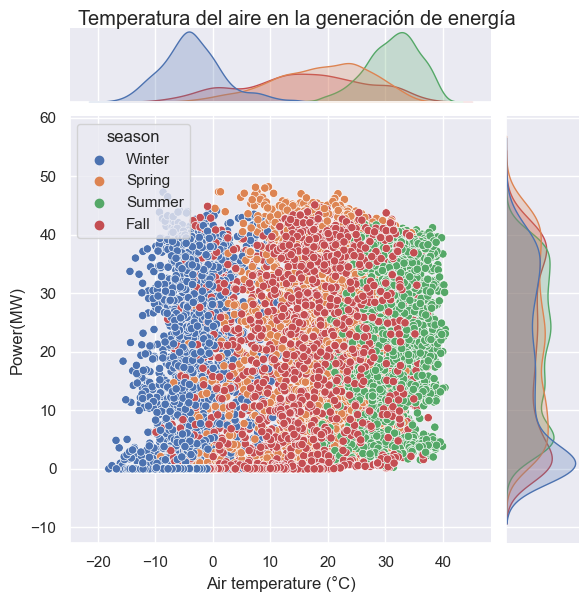

In [45]:
# Se crea un gráfico de dispersión conjunto (jointplot) utilizando seaborn
# Se utiliza filtered_data como el conjunto de datos
# x="Air temperature (°C)" indica que "Air temperature (°C)" será el eje x del gráfico
# y="Power (MW)" indica que "Power (MW)" será el eje y del gráfico
# hue='season' permite diferenciar las observaciones por estación utilizando diferentes colores
g = sns.jointplot(data=filtered_data, x="Air temperature  (°C) ", y="Power (MW)", hue='season')

# Se establecen las etiquetas de los ejes x e y del gráfico
g.set_axis_labels(xlabel=("Air temperature (°C)"), ylabel=("Power(MW)")) 

# Se establece el título de la figura
g.figure.suptitle("Temperatura del aire en la generación de energía", y=1)

# Se muestra el gráfico de dispersión conjunto
plt.show()


En en el caso de la temperatura, también vemos como no exite una relación lineal. Sin embargo, es más evidente como la temperatuars bajas se concentran durante el invierno (azul), como durante la otoño (rojo) y primavera (naranja), se dan la temperaturas más templadas y en verano (verde) las más altas.

##### Humedad relativa

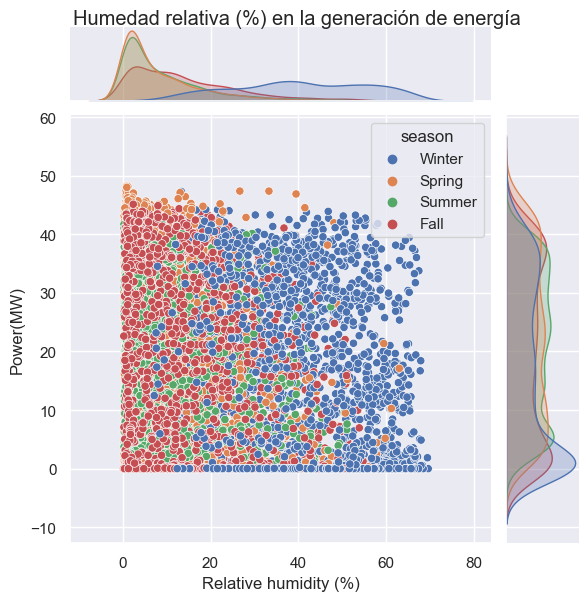

In [46]:
# Se crea un gráfico de dispersión conjunto (jointplot) utilizando seaborn
# Se utiliza filtered_data como el conjunto de datos
# x="Relative humidity (%)" indica que "Relative humidity (%)" será el eje x del gráfico
# y="Power (MW)" indica que "Power (MW)" será el eje y del gráfico
# hue='season' permite diferenciar las observaciones por estación utilizando diferentes colores
g = sns.jointplot(data=filtered_data, x="Relative humidity (%)", y="Power (MW)", hue='season')

# Se establecen las etiquetas de los ejes x e y del gráfico
g.set_axis_labels(xlabel=("Relative humidity (%)"), ylabel=("Power(MW)")) 

# Se establece el título de la figura
g.figure.suptitle("Humedad relativa (%) en la generación de energía", y=1)

# Se muestra el gráfico de dispersión conjunto
plt.show()


En cuanto a la humedad relativa, observamos que la mayoría de los datos se sitúan por debajo del 20%, sin mostrar una relación lineal clara con la producción de energía, ya que se distribuyen de manera uniforme. Este bajo nivel de humedad resulta comprensible, dado que, como mencionamos anteriormente, es posible que la planta solar esté ubicada en una región desértica entre China y Mongolia.

Por último, cabe destacar que durante las épocas de verano (verde) y primavera (naranja), se registran niveles más bajos de humedad. Esto podría atribuirse al incremento en la duración de los días, lo que permite que la radiación solar evapore la humedad durante el día, disminuyendo su valor. En contraste, durante el invierno (azul), donde las noches son más largas, la humedad tiende a aumentar, ya que no es evaporada por la menor exposición solar.

#### Multicolinearidad

Como observamos en la tabla de correlaciones, es posible que puede existir multicolinearidad entre nuestras variables. Para comprobarlo vamos a calcular los valores VIF, los cuales si son mayores de 10 indica que esa variables puede provocar multicolinearidad.

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Se crea un DataFrame vacío para almacenar los resultados del VIF
vif_data = pd.DataFrame()

# Se seleccionan las características para calcular el VIF
# Se eliminan las columnas 'Power (MW)', 'hour' y 'day_of_year' ya que probablemente sean variables dependientes o no necesarias para el cálculo
X = hourly_data.drop(['Power (MW)', 'hour', 'day_of_year'], axis=1)

# Se añade la columna "feature" al DataFrame vif_data
# Esta columna contendrá los nombres de las características
vif_data["feature"] = X.columns

# Se calcula el VIF para cada característica
# Se itera sobre todas las características y se calcula el VIF utilizando el método variance_inflation_factor
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]

# Se imprime el DataFrame vif_data
print(vif_data)


                               feature        VIF
0        Total solar irradiance (W/m2)   5.358820
1      Direct normal irradiance (W/m2)   2.441257
2  Global horizontal irradiance (W/m2)   2.873401
3               Air temperature  (°C)    4.107896
4                     Atmosphere (hpa)  10.167996
5                Relative humidity (%)   5.464716


Comprobamos como solamente la varaible Atmosphere tiene un valor VIF mayor de 10, por lo que vamos a eliminarla de nustro datset para los iguiente pasos.

In [48]:
# Se crea un DataFrame vacío para almacenar los resultados del VIF
vif_data = pd.DataFrame()

# Se seleccionan las características para calcular el VIF
# Se eliminan las columnas 'Power (MW)', 'Atmosphere (hpa)', 'hour' y 'day_of_year' ya que probablemente sean variables dependientes o no necesarias para el cálculo
X = hourly_data.drop(['Power (MW)', 'Atmosphere (hpa)', 'hour', 'day_of_year'], axis=1)

# Se añade la columna "feature" al DataFrame vif_data
# Esta columna contendrá los nombres de las características
vif_data["feature"] = X.columns

# Se calcula el VIF para cada característica
# Se itera sobre todas las características y se calcula el VIF utilizando el método variance_inflation_factor
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]

# Se imprime el DataFrame vif_data
print(vif_data)


                               feature       VIF
0        Total solar irradiance (W/m2)  5.314923
1      Direct normal irradiance (W/m2)  2.411486
2  Global horizontal irradiance (W/m2)  2.870729
3               Air temperature  (°C)   1.493468
4                Relative humidity (%)  1.099754


Al eliminarla vemos que ya no tenemos ningun valor superior a 10, por lo que estás serán las variables seleccionadas para el estudio.

### Estacionalidad
#### Test de Dickey-Fuller

In [49]:
from statsmodels.tsa.stattools import adfuller

# Se crea un diccionario vacío para almacenar los resultados de la prueba ADF
adfull = {}

# Se itera sobre todas las columnas del DataFrame hourly_data excepto 'Atmosphere (hpa)', 'hour' y 'day_of_year'
for column in hourly_data.drop(['Atmosphere (hpa)', 'hour', 'day_of_year'], axis=1).columns:
    # Se selecciona la columna actual como la serie temporal para realizar la prueba ADF
    X = hourly_data[column].values
    # Se aplica la prueba ADF a la serie temporal actual
    result = adfuller(X)
    # Se almacena el valor p obtenido de la prueba ADF en el diccionario adfull con el nombre de la columna como clave
    adfull[column] = [result[1]]

    # Se imprime el valor p obtenido de la prueba ADF para la columna actual
    print('P-value para {}: {}'.format(column, result[1]))


P-value para Total solar irradiance (W/m2): 2.4340796530621406e-26
P-value para Direct normal irradiance (W/m2): 6.678768810405342e-16
P-value para Global horizontal irradiance (W/m2): 3.789015028785508e-14
P-value para Air temperature  (°C) : 0.198957493432718
P-value para Relative humidity (%): 1.365018678555753e-05
P-value para Power (MW): 3.645646743257675e-27


Como la variable Air temperature tiene un p-valor superior a 0.05, por lo que los datos en general tienen un comportamiento constante, por lo que no la introduciremos en el modelo

In [50]:
# Se eliminan las columnas 'Atmosphere (hpa)', 'hour', 'day_of_year' y 'Air temperature (°C)' del DataFrame hourly_data
# axis=1 indica que se eliminarán columnas en lugar de filas
# inplace=True hace que los cambios se apliquen directamente al DataFrame hourly_data
hourly_data.drop(['Atmosphere (hpa)', 'hour', 'day_of_year', 'Air temperature  (°C) '], axis=1, inplace=True)

In [51]:
# Dataset final
hourly_data.head()

Total solar irradiance (W/m2)  \
Time                                                 
2019-01-01 00:00:00                            0.0   
2019-01-01 01:00:00                            0.0   
2019-01-01 02:00:00                            0.0   
2019-01-01 03:00:00                            0.0   
2019-01-01 04:00:00                            0.0   

                     Direct normal irradiance (W/m2)  \
Time                                                   
2019-01-01 00:00:00                              0.0   
2019-01-01 01:00:00                              0.0   
2019-01-01 02:00:00                              0.0   
2019-01-01 03:00:00                              0.0   
2019-01-01 04:00:00                              0.0   

                     Global horizontal irradiance (W/m2)  \
Time                                                       
2019-01-01 00:00:00                                  0.0   
2019-01-01 01:00:00                                  0.0   
2019-01-01 02:00:00                                  0.0   
2019-01-01 03:00:00                                  0.0   
2019-01-01 04:00:00                                  0.0   

                     Relative humidity (%)  Power (MW)  
Time                                                    
2019-01-01 00:00:00                 38.850         0.0  
2019-01-01 01:00:00                 38.850         0.0  
2019-01-01 02:00:00                 38.350         0.0  
2019-01-01 03:00:00                 40.075         0.0  
2019-01-01 04:00:00                 42.050         0.0

In [52]:
# Mostramos las columnas y filas del dataset final
print(f'El dataset tiene {hourly_data.shape[0]} filas y {hourly_data.shape[1]} columnas')

El dataset tiene 16500 filas y 5 columnas


In [53]:
# hourly_data.to_csv('data/PV_data.csv')

En base a los resltados obtenidos vamos a realizar un estudio de la estacionalidad de nuestros datos mediante la despomposición STL

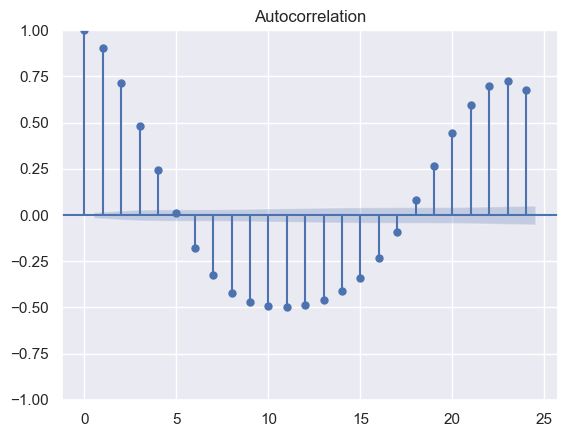

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(hourly_data['Power (MW)'], lags=24)
plt.show()

Podemos ver como en 24 (horas) tenemos el punto mas alto del pico, por lo que será el valor empleado para encontrar tendencias en la enegía fotvoltaica

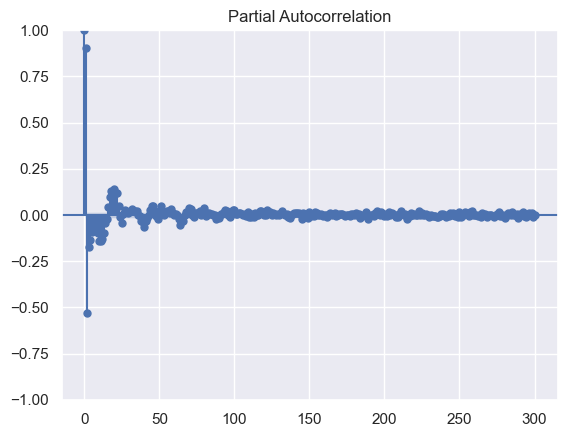

In [55]:
plt.figsize=(20,5)
plot_pacf(hourly_data['Power (MW)'], lags=300)
plt.show()